##HuggingFace 커스텀 프로젝트 만들기

HuggingFrace Framework
<br/>Development Environment
<br/>KcBERT-base MLM Finetune
<br/>bert-base-cased MRPC Finetune
<br/>bert-base-uncased MRPC Finetune
<br/>bert_uncased_L-12_H-768_A-12 MRPC Finetune
<br/>Debugging

Transformer Pipeline
<br/>Text generation
<br/>Sentiment analysis
<br/>Question Answering
<br/>Text prediction
<br/>Text Summarization
<br/>Translation
<br/>Zero-Shot Learning

HuggingFrace MNLI Custom Project
<br/>개발 환경
<br/>데이터 정보
<br/>Processor
<br/>Huggingface Dataset
<br>코드 변경 예정
<br/>모델 구성
<br/>Tokenizer & Model
<br/>Huggingface Auto Classes
<br/>Tokenizing
<br/>Keras Moodel
<br/>Huggingface Trainer


HuggingFrace MRPC Custom Project
<br/>개발 환경
<br/>데이터 정보
<br/>Processor
<br/>Huggingface Dataset
<br/>모델 구성
<br/>Tokenizer & Model
<br/>Huggingface Auto Classes
<br/>Tokenizing
<br/>Keras Moodel
<br/>Huggingface Trainer
<br/>모델 평가

결론
<br/>참고문헌

#HuggingFrace Framework

##Development Environment

In [2]:
import os
import sys
import json
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
from urllib import request
from IPython.display import HTML
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

<br/>

##KcBERT-base MLM Finetune

[Beomi/2021-03-15-kcbert-mlm-finetune-with-petition-dataset.ipynb](https://gist.github.com/Beomi/972c6442a9c15a22dfd1903d0bb0f577)

In [ ]:
cd drive/MyDrive/lms/huggingface_glue_task

In [24]:
pwd

'/content/drive/MyDrive/lms/huggingface_glue_task'

In [ ]:
!pip install -q Korpora soynlp "kss<2.6" transformers "datasets >= 1.1.3" "sentencepiece != 0.1.92" protobuf

In [ ]:
import re
from Korpora import Korpora
from glob import glob
from tqdm.auto import tqdm
from soynlp.normalizer import repeat_normalize
from kss import split_sentences

In [ ]:
Korpora.fetch('korean_petitions', root_dir='data/Korpora')
dataset = glob('data/Korpora/korean_petitions/petitions*')

In [ ]:
df = pd.concat([pd.read_json(i, lines=True) for i in tqdm(dataset)])
agreed_df = df[df['num_agree'] > 1000]

pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

def clean(x):
    x = pattern.sub(' ', x)
    x = url_pattern.sub('', x)
    x = x.strip()
    x = repeat_normalize(x, num_repeats=2)
    return x

contents = agreed_df['content'].map(clean).to_list()

with open('data/korean_petitions_safe.txt', 'w') as f:
    for doc in tqdm(contents):
        if doc:
            for line in split_sentences(doc):
                f.write(line+'\n')
            f.write('\n')
    f.close()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3704 [00:00<?, ?it/s]

[Error in google colab(python) while transliterating data into Indian language](https://stackoverflow.com/questions/73024976/error-in-google-colabpython-while-transliterating-data-into-indian-language)

AttributeError: module 'emoji' has no attribute 'UNICODE_EMOJI'
<br/>AttributeError로 인해 emoji가 작동하지 않아
<br/>데이터 전처리 과정에서 emoji를 실행하는 이모티콘 전처리 과정을 생략했다.

In [ ]:
!wget -O kcbert_base_mlm/run_mlm.py https://raw.githubusercontent.com/huggingface/transformers/72aee83ced5f31302c5e331d896412737287f976/examples/pytorch/language-modeling/run_mlm.py

In [ ]:
!python kcbert_base_mlm/run_mlm.py \
    --model_name_or_path beomi/kcbert-base \
    --train_file data/korean_petitions_safe.txt \
    --do_train \
    --output_dir kcbert_base_mlm/test_mlm

모델 [beomi/kcbert-base](https://huggingface.co/beomi/kcbert-base)를 사용한다.

In [ ]:
def read_model_result_json(json_path):
    with open(json_path, 'r') as f:
        json_data = json.load(f)
    return json_data

In [ ]:
CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))

json_path_list = ['kcbert_base_mlm/test_mlm/trainer_state.json', 'kcbert_base_mlm/test_mlm/train_results.json', 
                  'kcbert_base_mlm/test_mlm/config.json', 'kcbert_base_mlm/test_mlm/tokenizer_config.json']

for i in json_path_list:
  if 'trainer_state' in i:
      json_data = read_model_result_json(i)
      log_history_df = pd.DataFrame.from_dict(json_data['log_history']).fillna(" ")
  elif 'train_results' in i:
      json_data = read_model_result_json(i)
      train_results_df = pd.DataFrame([json_data])
  elif '/config' in i:
      json_data = read_model_result_json(i)
      config_json_df = pd.DataFrame.from_dict(json_data)
  elif 'tokenizer_config' in i:
      json_data = read_model_result_json(i)
      tokenizer_config_df = pd.DataFrame([json_data])

display(log_history_df)
print("\n" * 2)
display(train_results_df)
print("\n"* 2)
display(config_json_df)
print("\n"* 2)
display(tokenizer_config_df)

,epoch,learning_rate,loss,step,total_flos,train_loss,train_runtime,train_samples_per_second,train_steps_per_second
0,0.58,0.00004,2.6954,500,,,,,
1,1.17,0.000031,2.6017,1000,,,,,
2,1.75,0.000021,2.4854,1500,,,,,
3,2.34,0.000011,2.4172,2000,,,,,
4,2.92,0.000001,2.3733,2500,,,,,
5,3.00,,,2565,3164144673916800.0,2.510174,906.0199,22.645,2.831


,epoch,train_loss,train_runtime,train_samples,train_samples_per_second,train_steps_per_second
0,3.0,2.510174,906.0199,6839,22.645,2.831


,_name_or_path,architectures,attention_probs_dropout_prob,classifier_dropout,directionality,hidden_act,hidden_dropout_prob,hidden_size,initializer_range,intermediate_size,...,pooler_num_attention_heads,pooler_num_fc_layers,pooler_size_per_head,pooler_type,position_embedding_type,torch_dtype,transformers_version,type_vocab_size,use_cache,vocab_size
0,beomi/kcbert-base,BertForMaskedLM,0.1,None,bidi,gelu,0.1,768,0.02,3072,...,12,3,128,first_token_transform,absolute,float32,4.21.1,2,True,30000


,cls_token,do_basic_tokenize,do_lower_case,mask_token,model_max_length,name_or_path,never_split,pad_token,sep_token,special_tokens_map_file,strip_accents,tokenize_chinese_chars,tokenizer_class,unk_token
0,[CLS],True,False,[MASK],300,beomi/kcbert-base,None,[PAD],[SEP],None,None,True,BertTokenizer,[UNK]


<br/><br/>

##bert-base-cased MRPC Finetune

In [23]:
pwd

'/content/drive/MyDrive/lms/huggingface_glue_task'

In [ ]:
!git clone -b v4.21.1 https://github.com/huggingface/transformers.git

In [ ]:
mv transformers transfomers_v4.21.1

In [ ]:
cd transfomers_v4.21.1

In [ ]:
!pip install -e .

In [ ]:
!pip install -q datasets huggingface_hub evaluate transformers

In [ ]:
!pip install -q protobuf sentencepiece

[HuggingFace Installation](https://huggingface.co/docs/transformers/installation#installing-from-source%60)
<br/>[huggingface/transformers](https://github.com/huggingface/transformers)
<br/>[huggingface/transformers/releases](https://github.com/huggingface/transformers/releases)
<br/>[# v4.21.1: Patch release](https://github.com/huggingface/transformers/releases/tag/v4.21.1)

run_glue.py 파일의 check_min_version에 dev가 붙어있다면 Github의 main branch가 아니라 최근 release 된 Tag를 찾아 다운로드한다.

In [ ]:
!python examples/tensorflow/text-classification/run_glue.py \
	--model_name_or_path bert-base-cased \
	--task_name mrpc \
	--output_dir bert_base_cased_mrpc \
	--overwrite_output_dir \
	--do_train \
	--do_eval \
	--num_train_epochs 1 \
	--save_steps 20000

모델 [bert-base-cased](https://huggingface.co/bert-base-cased)를 사용한다.


AssertionError로 인해 실행되지 않는다.

AssertionError: in user code:
<br/>File "/usr/local/lib/python3.7/dist-packages/datasets/arrow_dataset.py", line 475, in split_features_and_labels  *
<br/>assert set(features.keys()).union(labels.keys()) == set(input_batch.keys())

10가지 GLUE Task 중 MRPC를 수행하는 예제 코드이다.
<br/>Huggingface의 Framework 기반으로 모델 [bert-base-uncased](https://huggingface.co/bert-base-cased)을 활용하여 MRPC Task를 수행한다.
<br/>만약 task_name 및 다른 파라미터를 적절히 변경한 후 수행하면 다른 GLUE task도 수행할 수 있다.

<br/>

##bert-base-uncased MRPC Finetune

In [ ]:
cd ..

In [ ]:
pwd

'/content/drive/MyDrive/lms/huggingface_glue_task'

In [ ]:
!git clone https://github.com/google-research/bert.git

[google-research/bert](https://github.com/google-research/bert)

In [ ]:
url = "https://gist.githubusercontent.com/vlasenkoalexey/fef1601580f269eca73bf26a198595f3/raw/db67cdf22eb5bd7efe376205e8a95028942e263d/download_glue_data.py"
savename = "data/download_glue_data.py"

request.urlretrieve(url, savename)

In [ ]:
!python data/download_glue_data.py --data_dir='data' --tasks='MRPC'

Processing MRPC...
	Completed!


[W4ngatang/download_glue_data.py](https://gist.github.com/W4ngatang/60c2bdb54d156a41194446737ce03e2e)을 실행하여 MRPC 데이터를 다운로드 받을 때
<br/>AttributeError: 'NoneType' object has no attribute 'urlretrieve'가 발생한다.
<br/>이를 디버깅하여 코드를 수정한 파일이 [vlasenkoalexe/download_glue_data.py](https://gist.github.com/vlasenkoalexey/fef1601580f269eca73bf26a198595f3)이다.

In [ ]:
# original code file
with open("bert/optimization.py", "r") as f:
    code_line = f.read().splitlines()
for code in code_line:
    if  "class AdamWeightDecayOptimizer" in code:
      print("", code)

 class AdamWeightDecayOptimizer(tf.train.Optimizer):


In [ ]:
# revised code file
with open("bert/optimization.py", "r") as f:
    code_line = f.read().splitlines()
for code in code_line:
    if  "class AdamWeightDecayOptimizer" in code:
      print("", code)

 class AdamWeightDecayOptimizer(tf.compat.v1.train.Optimizer):


[Error importing BERT: module 'tensorflow._api.v2.train' has no attribute 'Optimizer'](https://stackoverflow.com/questions/61250311/error-importing-bert-module-tensorflow-api-v2-train-has-no-attribute-optimi)

AttributeError: module 'tensorflow._api.v2.train' has no attribute 'Optimizer'가 발생하기 때문에
<br/>파일 optimization.py에서 class AdamWeightDecayOptimizer(tf.train.Optimizer)를 
<br/>class AdamWeightDecayOptimizer(tf.compat.v1.train.Optimizer)로 수정한다.

In [ ]:
# original code file
with open("bert/run_classifier.py", "r") as f:
    code_line = f.read().splitlines()
for code in code_line:
    if  "tf.flags" in code:
      print("", code)
    elif "flags.FLAGS" in code:
      print("", code)
    elif "tf.app" in code:
      print("", code)

 flags = tf.flags
 FLAGS = flags.FLAGS
 tf.flags.DEFINE_string(
 tf.flags.DEFINE_string(
 tf.flags.DEFINE_string(
 tf.flags.DEFINE_string("master", None, "[Optional] TensorFlow master URL.")
   tf.app.run()


In [ ]:
# revised code file
with open("bert/run_classifier.py", "r") as f:
    code_line = f.read().splitlines()
for code in code_line:
    if  "tf.compat.v1" in code:
      print("", code)

 flags = tf.compat.v1.flags
 tf.compat.v1.flags.DEFINE_string(
 tf.compat.v1.flags.DEFINE_string(
 tf.compat.v1.flags.DEFINE_string(
 tf.compat.v1.flags.DEFINE_string("master", None, "[Optional] TensorFlow master URL.")
   tf.compat.v1.app.run()


[AttributeError: module 'tensorflow' has no attribute 'flags' #1754](https://github.com/tensorflow/tensor2tensor/issues/1754)

AttributeError: module 'tensorflow' has no attribute 'flags'가 발생하기 때문에
<br/>파일 run_classifier.py에서 tf.flags.FLAGS를 tf.compat.v1.flags.Flag로 수정한다.

[AttributeError: module 'tensorflow' has no attribute 'app' #34431](https://github.com/tensorflow/tensorflow/issues/34431)

AttributeError: module 'tensorflow' has no attribute 'app'가 발생하기 때문에
<br/>파일 run_classifier.py에서 tf.app를 tf.compat.v1.app로 수정한다.

In [ ]:
!python bert/run_classifier.py \
  --task_name MRPC \
  --do_train \
  --do_eval \
  --do_lower_case \
  --data_dir data/glue_data/MRPC \
  --bert_model bert-base-uncased \
  --max_seq_length 128 \
  --train_batch_size 32 \
  --learning_rate 2e-5 \
  --num_train_epochs 3.0 \
  --output_dir test_mrpc

Traceback (most recent call last):
  File "bert/run_classifier.py", line 981, in <module>
    tf.compat.v1.app.run()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/platform/app.py", line 36, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 302, in run
    flags_parser,
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 371, in _run_init
    flags_parser=flags_parser,
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 216, in _register_and_parse_flags_with_usage
    args_to_main = flags_parser(original_argv)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/platform/app.py", line 27, in _parse_flags_tolerate_undef
    return flags.FLAGS(_sys.argv if argv is None else argv, known_only=True)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/platform/flags.py", line 109, in __call__
    return self.__dict__['__wrapped

모델 [bert-base-uncased](https://huggingface.co/bert-base-uncased)를 사용한다.

[Zhen-Dong/QBERT/NLP-quantization/Fine-tuning with BERT: examples](https://githubmemory.com/index.php/repo/Zhen-Dong/QBERT)

absl.flags._exceptions.IllegalFlagValueError가 발생한다.

<br/>

##bert_uncased_L-12_H-768_A-12 MRPC Finetune

In [ ]:
pwd

'/content/drive/MyDrive/lms/huggingface_glue_task'

In [21]:
# !git clone https://github.com/google-research/bert.git
ls

bert/                               kcbert_base_mlm/     transfomers_v4.21.1/
bert_uncased_L-12_H-768_A-12_mrpc/  library_version.txt
data/                               test_mnli/


[google-research/bert](https://github.com/google-research/bert)

In [ ]:
url_path_dict = {"https://huggingface.co/google/bert_uncased_L-12_H-768_A-12/blob/main/vocab.txt" : "data/bert_uncased_L-12_H-768_A-12/vocab.txt",
            "https://huggingface.co/google/bert_uncased_L-12_H-768_A-12/blob/main/bert_model.ckpt.data-00000-of-00001" : "data/bert_uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001",
            "https://huggingface.co/google/bert_uncased_L-12_H-768_A-12/blob/main/config.json" : "data/bert_uncased_L-12_H-768_A-12/config.json"}

for url, save_path in url_path_dict.items():
  request.urlretrieve(url, save_path)

모델 [google/bert_uncased_L-12_H-768_A-12](https://huggingface.co/google/bert_uncased_L-12_H-768_A-12/tree/main)를 사용한다.

In [ ]:
# original code file
with open("bert/run_classifier.py", "r") as f:
    code_line = f.read().splitlines()
for code in code_line:
    if "tf.logging" in code:
      print("", code)
    elif "do_lower_case" in code:
      print("", code)

     "do_lower_case", True,
     tf.logging.info("*** Example ***")
     tf.logging.info("guid: %s" % (example.guid))
     tf.logging.info("tokens: %s" % " ".join(
     tf.logging.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
     tf.logging.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
     tf.logging.info("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
     tf.logging.info("label: %s (id = %d)" % (example.label, label_id))
       tf.logging.info("Writing example %d of %d" % (ex_index, len(examples)))
     tf.logging.info("*** Features ***")
       tf.logging.info("  name = %s, shape = %s" % (name, features[name].shape))
     tf.logging.info("**** Trainable Variables ****")
       tf.logging.info("  name = %s, shape = %s%s", var.name, var.shape,
       tf.logging.info("Writing example %d of %d" % (ex_index, len(examples)))
   tf.logging.set_verbosity(tf.logging.INFO)
   tokenization.validate_case_matches_checkpoint(FLAGS.do_lower_case,
  

In [ ]:
#revised code file
with open("bert/run_classifier.py", "r") as f:
    code_line = f.read().splitlines()
for code in code_line:
    if "tf.compat.v1.logging" in code:
      print("", code)
    elif "do_lower_case" in code:
      print("", code)

     tf.compat.v1.logging.info("*** Example ***")
     tf.compat.v1.logging.info("guid: %s" % (example.guid))
     tf.compat.v1.logging.info("tokens: %s" % " ".join(
     tf.compat.v1.logging.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
     tf.compat.v1.logging.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
     tf.compat.v1.logging.info("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
     tf.compat.v1.logging.info("label: %s (id = %d)" % (example.label, label_id))
       tf.compat.v1.logging.info("Writing example %d of %d" % (ex_index, len(examples)))
     tf.compat.v1.logging.info("*** Features ***")
       tf.compat.v1.logging.info("  name = %s, shape = %s" % (name, features[name].shape))
     tf.compat.v1.logging.info("**** Trainable Variables ****")
       tf.compat.v1.logging.info("  name = %s, shape = %s%s", var.name, var.shape,
       tf.compat.v1.logging.info("Writing example %d of %d" % (ex_index, len(examples)))
   tf.compat.v1

[AttributeError: module 'tensorflow' has no attribute 'logging'](https://systemout.tistory.com/8)

AttributeError: module 'tensorflow' has no attribute 'logging'이 발생하기 때문에
<br/>파일 run_classifier.py에서 tf.logging 대신 tf.compat.v1.logging로 수정한다.

AttributeError: type object 'Flag' has no attribute 'do_lower_case'가 발생하기 때문에
<br/>파일 run_classifier.py에서 do_lower_case를 제외한다.

In [ ]:
!python bert/run_classifier.py \
  --task_name=MRPC \
  --do_train=true \
  --do_eval=true \
  --data_dir data/MRPC \
  --vocab_file data/bert_uncased_L-12_H-768_A-12/vocab.txt \
  --bert_config_file data/bert_uncased_L-12_H-768_A-12/config.json \
  --init_checkpoin data/bert_uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001 \
  --max_seq_length=128 \
  --train_batch_size=32 \
  --learning_rate=2e-5 \
  --num_train_epochs=3.0 \
  --output_dir bert_uncased_L-12_H-768_A-12_mrpc \

Traceback (most recent call last):
  File "bert/run_classifier.py", line 60, in <module>
    "Whether to lower case the input text. Should be True for uncased "
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/platform/flags.py", line 55, in wrapper
    return original_function(*args, **kwargs)
TypeError: DEFINE_boolean() missing 2 required positional arguments: 'default' and 'help'


[google-research/bert/Sentence (and sentence-pair) classification tasks](https://github.com/google-research/bert)

TypeError: DEFINE_boolean() missing 2 required positional arguments: 'default' and 'help'가 발생한다.

<br/>

##Debugging

HuggingFace에 등록된 MRPC 모델의 CLI 코드를 실행했다.
<br/>bert-base-cased MRPC
<br/>bert-base-uncased MRPC
<br/>bert_uncased_L-12_H-768_A-12 MRPC

Tensorflow 버전 차이 때문에 AttributeError, TyperError가 발생한다.
<br/>py 파일을 여러 번 수정해도 또 다른 에러가 떠서 아예 코드 전체를 바꿔야 하는 디버깅 작업이 요구된다.


이러한 상황에서 그 작동 코드의 옛날 버전에 맞는 가상환경을 구축하거나
<br/>코드 전체를 바꿔서 원작자에게 연락하여 Github Contributor가 되는 문제 해결 방법이 있는 것인가?
<br/>개발자는 모델 개발과 배포 프로세스에서 발생한 이슈에 어떻게 대처하는가?

<br/>

#Transformer Pipeline

[huggingface transformer basic usage](https://www.kaggle.com/code/nageshsingh/huggingface-transformer-basic-usage)

##Text generation

In [ ]:
pwd

'/content/drive/MyDrive/lms/huggingface_glue_task'

In [22]:
ls

bert/                               kcbert_base_mlm/     transfomers_v4.21.1/
bert_uncased_L-12_H-768_A-12_mrpc/  library_version.txt
data/                               test_mnli/


In [ ]:
cd transfomers_v4.21.1

In [ ]:
from transformers import pipeline, set_seed

In [ ]:
generator = pipeline('text-generation', model='gpt2')
set_seed(123)
text_generation_dict = generator("Hello, I like to play soccer,", max_length=60, num_return_sequences=7)
print("\n")
pd.set_option('display.max_colwidth', None)
text_generation_df = pd.DataFrame.from_dict(text_generation_dict)
display(text_generation_df.style.set_properties(**{'white-space': 'pre-wrap'}))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


,generated_text
0,"Hello, I like to play soccer, not basketball. It's an interesting sport and I like that. ""Well, it's not like I'm playing. It's more like I'm just not really doing it, playing a team game in Brazil. No I don't. I'm"
1,"Hello, I like to play soccer, I am very good at that,"" said Nel-Kaem. The 30-year old center forward played for the Czech Republic under the former president Viktor Orban this past year and played collegiately in his position for the Republic and the European"
2,"Hello, I like to play soccer, but I am not one of those people who likes to play in the middle of the ball. It might be a sign or an excuse to get up early, but it seems like an important issue to me to take care of."" Still, he added"
3,"Hello, I like to play soccer, so I like to spend a lot of time with those kids in the morning, just walking by the water."""
4,"Hello, I like to play soccer, it is the only way I have managed to do it since then."" ""Yes,"" said Harry, and he turned to look at him. He was wearing only a short coat but he seemed pleased at how he managed to play even in this dark night"
5,"Hello, I like to play soccer, you know, and I do play soccer too,"" says Darnell, who played on his soccer team. ""But football, it's a different environment, it's much more physical and has many better technical abilities. I didn't feel like I had to"
6,"Hello, I like to play soccer, but I play basketball. The way I play, I'm not in my late 40's but I'm ready, I'm ready to be here."" One fan at the home of Portland's star midfielder is even taking advantage of the chance to get into"


##Sentiment analysis

In [ ]:
classifier = pipeline('sentiment-analysis', model='gpt2')
set_seed(123)
sentiment_anlysis_dict = classifier('We are very happy to introduce pipeline to the transformers repository.')
print("\n")
sentiment_anlysis_df = pd.DataFrame(sentiment_anlysis_dict).round(4)
sentiment_anlysis_df

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,label,score
0,LABEL_0,0.6714


##Question Answering

In [ ]:
question_answerer = pipeline('question-answering')
question_answering_dict = question_answerer({
    'question': 'What is the Newtons third law of motion?',
    'context': 'Newton’s third law of motion states that, "For every action there is equal and opposite reaction"'})
print("\n")
question_answering_df = pd.DataFrame([question_answering_dict]).round(4)
question_answering_df 

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


,score,start,end,answer
0,0.6063,42,97,"""For every action there is equal and opposite reaction"""


##Text prediction

In [ ]:
unmasker = pipeline('fill-mask', model='bert-base-cased')
fill_mask_dict = unmasker("Hello, My name is [MASK].")
print("\n")
fill_mask_df = pd.DataFrame.from_dict(fill_mask_dict).round(4)
fill_mask_df

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,score,token,token_str,sequence
0,0.0079,1681,David,"Hello, My name is David."
1,0.0073,5036,Kate,"Hello, My name is Kate."
2,0.0071,2687,Sam,"Hello, My name is Sam."
3,0.0062,1600,James,"Hello, My name is James."
4,0.0061,4117,Charlie,"Hello, My name is Charlie."


##Text Summarization

[Wikipedia Apollo program](https://en.wikipedia.org/wiki/Apollo_program)

In [ ]:
summarizer = pipeline("summarization")

ARTICLE = """The Apollo program, also known as Project Apollo, was the third United States human spaceflight program carried out by the National Aeronautics and Space Administration (NASA), which accomplished landing the first humans on the Moon from 1969 to 1972.
First conceived during Dwight D. Eisenhower's administration as a three-man spacecraft to follow the one-man Project Mercury which put the first Americans in space,
Apollo was later dedicated to President John F. Kennedy's national goal of "landing a man on the Moon and returning him safely to the Earth" by the end of the 1960s, which he proposed in a May 25, 1961, address to Congress. 
Project Mercury was followed by the two-man ProjectGemini (1962–66). 
The first manned flight of Apollo was in 1968.
Apollo ran from 1961 to 1972, and was supported by the two-man Gemini program which ran concurrently with it from 1962 to 1966. 
Gemini missions developed some of the space travel techniques that were necessary for the success of the Apollo missions.
Apollo used Saturn family rockets as launch vehicles. 
Apollo/Saturn vehicles were also used for an Apollo Applications Program, which consisted of Skylab, a space station that supported three manned missions in 1973–74, and the Apollo–Soyuz Test Project, a joint Earth orbit mission with the Soviet Union in 1975.
 """

summary = summarizer(ARTICLE, max_length=130, min_length=30, do_sample=False)[0]

print("\n")
print("Summary")
print(summary['summary_text'])

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.




Summary
 The first manned flight of Apollo ran from 1961 to 1972 . The Apollo program was followed by the two-man ProjectGemini . It was the third mission to land on the Moon .


##Translation

In [ ]:
# English to Spain
translator_ger = pipeline("translation_en_to_de")
ger_text = translator_ger("Spaghetti is the plural form of the Italian word spaghetto, which is a diminutive of spago, meaning thin string or twine.", max_length=40)[0]['translation_text']

# English to French
translator_fr = pipeline('translation_en_to_fr')
fr_text = translator_fr("Spaghetti is the plural form of the Italian word spaghetto, which is a diminutive of spago, meaning thin string or twine.",  max_length=40)[0]['translation_text']

print("\n")
print("German:", ger_text)
print("French:", fr_text)

No model was supplied, defaulted to t5-base and revision 686f1db (https://huggingface.co/t5-base).
Using a pipeline without specifying a model name and revision in production is not recommended.
Your input_length: 41 is bigger than 0.9 * max_length: 40. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
No model was supplied, defaulted to t5-base and revision 686f1db (https://huggingface.co/t5-base).
Using a pipeline without specifying a model name and revision in production is not recommended.
Your input_length: 41 is bigger than 0.9 * max_length: 40. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)




German: Spaghetti ist die plurale Form des italienischen Wortes spaghetto, das ein Abkürzung von spago ist, was dünn
French: Spaghetti est la forme plurielle du mot italien spaghetto, qui est un diminutif de spago, signifiant mince ficelle ou 


##Zero-Shot Learning

In [ ]:
classifier_zsl = pipeline("zero-shot-classification")

sequence_to_classify = "Bill gates founded a company called Microsoft in the year 1975"
candidate_labels = ["computer", "sports",'leadership','business', "politics", "startup"]
classifier_zsl_dict = classifier_zsl(sequence_to_classify, candidate_labels)
keys = ('labels', 'scores')
classifier_zsl_dict_slice = {k: classifier_zsl_dict[k] for k in keys}

print("\n")
classifier_zsl_df = pd.DataFrame.from_dict(classifier_zsl_dict_slice).round(4)
classifier_zsl_df

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


,labels,scores
0,business,0.5354
1,leadership,0.2195
2,startup,0.1633
3,computer,0.0759
4,sports,0.0034
5,politics,0.0024


<br/>

#HuggingFrace MNLI Custom Project

GLUE MNLI Task를 Custom Project로 구성한다.

##개발 환경

In [ ]:
pwd

'/content/drive/MyDrive/lms/huggingface_glue_task/transfomers_v4.21.1'

[huggingface/transformers/releases](https://github.com/huggingface/transformers/releases)
<br/>[# v4.21.1: Patch release](https://github.com/huggingface/transformers/releases/tag/v4.21.1)

In [ ]:
!pip install tensorflow-datasets -U

tensorflow-datasets를 이용하여 glue/mnli를 다운로드하려면 tensorflow-datasets 라이브러리 버전을 업그레이드한다.

In [ ]:
!pip install -e .

In [ ]:
!pip install -q datasets huggingface_hub evaluate transformers

In [ ]:
!pip install -q protobuf sentencepiece

In [ ]:
import os
import re
import json
import time
import random
import pprint
import numpy as np
import pandas as pd
from datetime import date
from termcolor import colored
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
import datasets
from datasets import load_dataset

In [ ]:
from dataclasses import asdict
from argparse import ArgumentParser
from transformers import get_linear_schedule_with_warmup
from transformers import ElectraTokenizerFast, ElectraForSequenceClassification, AutoConfig, AdamW
from transformers.data.processors.utils import DataProcessor, InputExample, InputFeatures
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/huggingface_glue_task/library_version.txt'

In [ ]:
library_name = ['regex=', 'ujson=', 'numpy=', 'pandas=', 'termcolor=', 'matplotlib=',
                'tensorflow=', 'tensorflow-datasets=', 'transformers=']
library_version = []
count = 0

import sys
print(sys.version)
print()

with open('/content/drive/MyDrive/lms/huggingface_glue_task/library_version.txt', 'r') as f:
    lines = f.read().splitlines() 

for i in range(len(lines)):
  for line in lines[i:i+1]:
    for library in library_name:
      if library in line:
        library_version.append(line)
        count += 1
        print(line, end = '    ')
        if count % 3 == 0:
          print()

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

matplotlib==3.2.2    numpy==1.21.6    pandas==1.3.5    
regex==2022.6.2    sklearn-pandas==1.8.0    tensorflow==2.8.2+zzzcolab20220719082949    
tensorflow-datasets==4.6.0    termcolor==1.1.0    transformers==4.21.1    
ujson==5.4.0    

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다

##데이터 정보

In [ ]:
data, info = tfds.load('glue/mnli', with_info=True)

In [ ]:
info_splits = "Train Data Size: " + str(info.splits['train'].num_examples) + \
              "\nValidation Matched Data Size: " + str(info.splits['validation_matched'].num_examples) + \
              "\nValidation Mismatched Data Size: " + str(info.splits['validation_mismatched'].num_examples) + \
              "\nTest Matched Data Size: " + str(info.splits['test_matched'].num_examples) + \
              "\nTest Matched Data Size: " + str(info.splits['test_mismatched'].num_examples)

reorderlist = ['name', 'full_name', 'description', 'config_description', 'supervised_keys', 'disable_shuffling',
               'homepage', 'data_path', 'file_format', 'download_size', 'dataset_size', 'features', 'supervised_keys',
               'disable_shuffling', 'splits', 'citation', 'comment']

info_dict = pd.DataFrame({'tfds.core.DatasetInfo':{'name':info.name, 'full_name':info.full_name,
                                     'description':info.description.replace('resources', 'resources<br/>'),
                                     'config_description':'''The Multi-Genre Natural Language Inference Corpus is a crowdsourced
                                     collection of sentence pairs with textual entailment annotations. Given a premise sentence
                                     and a hypothesis sentence, the task is to predict whether the premise entails the hypothesis
                                     (entailment), contradicts the hypothesis (contradiction), or neither (neutral). The premise sentences are
                                     gathered from ten different sources, including transcribed speech, fiction, and government reports.
                                     We use the standard test set, for which we obtained private labels from the authors, and evaluate
                                     on both the matched (in-domain) and mismatched (cross-domain) section. We also use and recommend
                                     the SNLI corpus as 550k examples of auxiliary training data.''',
                                     'supervised_keys':info.supervised_keys, 
                                     'disable_shuffling':info.disable_shuffling, 'homepage':info.homepage, 
                                     'data_path': '~/tensorflow_datasets/glue/mnli/2.0.0',
                                     'file_format':info.file_format, 'download_size':info.download_size,
                                     'dataset_size':info.dataset_size, 'features':info.features,
                                      'supervised_keys':info.supervised_keys, 'disable_shuffling': info.disable_shuffling,
                                      'splits': info_splits.replace('\n', '<br/>'),  'citation':info.citation.replace('\n', '<br/>'),
                                      'comment': '''Note that each GLUE dataset has its own citation. Please see the source to see
                                      the correct citation for each contained dataset.'''
                                      }})
info_df = pd.DataFrame(info_dict)
info_df = info_df.reindex(reorderlist).reset_index()
from pandas import option_context
with option_context('display.max_colwidth', None):
  display(info_df.style.set_properties(**{'text-align': 'center'}))

,index,tfds.core.DatasetInfo
0,name,glue
1,full_name,glue/mnli/2.0.0
2,description,"GLUE, the General Language Understanding Evaluation benchmark (https://gluebenchmark.com/) is a collection of resources for training, evaluating, and analyzing natural language understanding systems."
3,config_description,"The Multi-Genre Natural Language Inference Corpus is a crowdsourced collection of sentence pairs with textual entailment annotations. Given a premise sentence and a hypothesis sentence, the task is to predict whether the premise entails the hypothesis (entailment), contradicts the hypothesis (contradiction), or neither (neutral). The premise sentences are gathered from ten different sources, including transcribed speech, fiction, and government reports. We use the standard test set, for which we obtained private labels from the authors, and evaluate on both the matched (in-domain) and mismatched (cross-domain) section. We also use and recommend the SNLI corpus as 550k examples of auxiliary training data."
4,supervised_keys,None
5,disable_shuffling,False
6,homepage,http://www.nyu.edu/projects/bowman/multinli/
7,data_path,~/tensorflow_datasets/glue/mnli/2.0.0
8,file_format,FileFormat.TFRECORD
9,download_size,298.29 MiB


<br/><br/><br/>

In [ ]:
def compact_dict_print(d, indent=''):

    bracket_count = 0
    line_count = 0 
    indent = "    "

    print("{")

    for key, value in d.items():
      bracket_count += 1
      print(indent + "'{}': ".format(key))
      print((indent * 2) + "<PrefetchDataset element_spec={")

      for nested_key in value:
          line_count += 1
          
          for inner_key in nested_key:
              if line_count == 1:
                print((indent * 2) + "'{}': '{}',".format(inner_key, nested_key[inner_key]))
                if inner_key == 'premise':
                  print()

              elif line_count == len(d[key]):
                line_count = 0

      print((indent * 2) + "...")

      if bracket_count < len(data):       
        print((indent * 2) + "}>, \n") 
      else:  
        print((indent * 2) + "}> \n")     

    print("}")

In [ ]:
compact_dict_print(data)

{
    'train': 
        <PrefetchDataset element_spec={
        'hypothesis': 'b'Meaningful partnerships with stakeholders is crucial.'',
        'idx': '16399',
        'label': '1',
        'premise': 'b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.'',

        ...
        }>, 

    'validation_matched': 
        <PrefetchDataset element_spec={
        'hypothesis': 'b'yeah lots of people for the right life '',
        'idx': '6287',
        'label': '0',
        'premise': 'b'uh-huh oh yeah all the people for right uh life or something'',

        ...
        }>, 

    'validation_mismatched': 
        <PrefetchDataset element_spec={
        'hypothesis': 'b"These projects are largely ignored and don't impact anyone. "',
        'idx': '

<br/><br/>

In [ ]:
examples = data['train'].take(1)
for example in examples:
    hypothesis = example['hypothesis']
    idx = example['idx']
    label = example['label']
    premise = example['premise']
    print('hypothesis')
    print(hypothesis)
    print('\nidx')
    print(idx)
    print('\nlabel')
    print(label)
    print('\npremise')
    print(premise)

hypothesis
tf.Tensor(b'Meaningful partnerships with stakeholders is crucial.', shape=(), dtype=string)

idx
tf.Tensor(16399, shape=(), dtype=int32)

label
tf.Tensor(1, shape=(), dtype=int64)

premise
tf.Tensor(b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.', shape=(), dtype=string)


<br/>

##Processor

In [ ]:
class DataProcessor:
    """Base class for data converters for sequence classification data sets."""

    def get_example_from_tensor_dict(self, tensor_dict):
        """
        Gets an example from a dict with tensorflow tensors.

        Args:
            tensor_dict: Keys and values should match the corresponding Glue
                tensorflow_dataset examples.
        """
        raise NotImplementedError()

    def get_train_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the dev set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the test set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    def tfds_map(self, example):
        """
        Some tensorflow_datasets datasets are not formatted the same way the GLUE datasets are. This method converts
        examples to the correct format.
        """
        if len(self.get_labels()) > 1:
            example.label = self.get_labels()[int(example.label)]
        return example

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            return list(csv.reader(f, delimiter="\t", quotechar=quotechar))

추상클래스인 Processor를 한번 상속받은 후 Sequence Classification Task를 수행하는 모델의 Processor 추상클래스인 DataProcessor이다.
<br/>추상클래스 상태이기 때문에 그대로 사용하면 NotImplementedError를 발생시키는 메소드들이 포함되어 있다.
<br/>이 메소드들을 Override해야 실제 사용 가능한 클래스가 얻어진다.

In [ ]:
class MnliProcessor(DataProcessor):
    """Processor for the MultiNLI data set (GLUE version)."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        warnings.filterwarnings("ignore", category=DeprecationWarning) 

    def get_example_from_tensor_dict(self, tensor_dict):
        """See base class."""
        return InputExample(
            tensor_dict["idx"].numpy(),
            tensor_dict["premise"].numpy().decode("utf-8"),
            tensor_dict["hypothesis"].numpy().decode("utf-8"),
            str(tensor_dict["label"].numpy()),
        )

    def get_train_examples(self, data_dir):
        """See base class."""
        print("LOOKING AT {}".format(os.path.join(data_dir, "train.tsv")))
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")
    
    def get_labels(self):
        """See base class."""
        return ["0", "1", "2"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training, dev and test sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = f"{set_type}-{line[0]}"
            text_a = line[8]
            text_b = line[9]
            label = None if set_type.startswith("test") else line[-1]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples

In [ ]:
class MnliMismatchedProcessor(MnliProcessor):
    """Processor for the MultiNLI Mismatched data set (GLUE version)."""

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "dev_mismatched.tsv")), "dev_mismatched")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "test_mismatched.tsv")), "test_mismatched")

MNLI 원본 데이터셋을 처리하여 모델에 입력할 수 있도록 정리해 주는 MnliProcessor, MnliMismatchedProcessor 클래스이다.

In [ ]:
processor = MnliProcessor()
examples = data['train'].take(1)

for example in examples:
    print('Original Data')
    pprint.pprint(example)  
    print("\n")
    example = processor.get_example_from_tensor_dict(example)
    print('Processed Data')
    pprint.pprint(example)

Original Data
{'hypothesis': <tf.Tensor: shape=(), dtype=string, numpy=b'Meaningful partnerships with stakeholders is crucial.'>,
 'idx': <tf.Tensor: shape=(), dtype=int32, numpy=16399>,
 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 'premise': <tf.Tensor: shape=(), dtype=string, numpy=b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.'>}


Processed Data
InputExample(guid=16399, text_a='In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.', text_b='Meaningful partnerships with stakeholders is cr

Processor는 'Raw Dataset를 Annotated Dataset으로 변환'하는 역할을 한다.
<br/>항목별로 text_a, text_b, label 등의 annotation이 포함된 InputExample로 변환된다.

<br/>

In [ ]:
examples = (data['train'].take(1))
for example in examples:
    example = processor.get_example_from_tensor_dict(example)
    example = processor.tfds_map(example)
    print('Processed Data')
    print(example)

Processed Data
InputExample(guid=16399, text_a='In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.', text_b='Meaningful partnerships with stakeholders is crucial.', label='1')


tfds_map 메소드를 활용한 경우이다. tfds_map는 label을 가공하는 메소드이다.

<br/>

In [ ]:
label_list = processor.get_labels()
label_list

['0', '1', '2']

In [ ]:
label_map = {label: i for i, label in enumerate(label_list)}
label_map

{'0': 0, '1': 1, '2': 2}

실제 label을 확인하여 Multiple Classification 문제로 정의되는 것을 확인한다.

<br/>

##Huggingface Dataset

In [ ]:
huggingface_mnli_dataset = load_dataset('glue', 'mnli')

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?it/s]

<br/>

In [ ]:
print(huggingface_mnli_dataset)

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})


Huggingface Datasets를 사용하면 DataProcessor를 사용할 필요없이 바로 사용가능하게 구성되어 있다.
<br/>Dataset Dictionary은 train dataset, validation dataset, test dataset으로 구성된다.
<br/>Dataset은 ‘premise’, ‘hypothesis’, ‘label’, ‘idx’(인덱스)로 구성된다.

<br/>

##코드 변경 예정

[Disaster Tweets : multiple vectorizers and models](https://www.kaggle.com/code/zinebkhanjari/disaster-tweets-multiple-vectorizers-and-models/notebook?scriptVersionId=52721572)

ElectraTokenizerFast.from_pretrained와 lectraForSequenceClassification.from_pretrained에서
<br/>모델 [google/electra-base-discriminator](https://huggingface.co/google/electra-base-discriminator)를 작동시키기 위해서는 모델 구성, 학습, 평가 코드를 수정한다.
<br/><br/>모델 구성
* Tokenizer & Model
* Huggingface Auto Classes
* Tokenizing

Keras Moodel
<br/>Huggingface Trainer
<br/><br/>ElectraForSequenceClassification.from_pretrained has no attruibute 'model.compile' 에러가 떠서 코드가 실행되지 않는다.
<br/>따라서 위의 Kaggle 사이트에 따라 코드를 수정하여 HuggingFrace MNLI Custom Project를 수행할 예정이다. 


<br/>

##모델 구성

###Tokenizer & Model

In [ ]:
tokenizer = ElectraTokenizerFast.from_pretrained('google/electra-base-discriminator')
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator')

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

MnliProcessor 클래스와 Framework를 결합하는 과정을 진행한다.
<br/>모델 [google/electra-base-discriminator](https://huggingface.co/google/electra-base-discriminator)를 사용한다.


<br/>

In [ ]:
import torch
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

MnliProcessor, MnliMismatchedProcessor 클래스와 Framework를 결합하는 과정을 진행한다.

In [ ]:
def _glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="claasification") :
    if max_length is None :
        max_length = tokenizer.max_len
    if label_list is None:
        label_list = processor.get_labels()
        print("Using label list %s" % (label_list))
        print("\n")

    label_map = {label: i for i, label in enumerate(label_list)}
    labels = [label_map[example.label] for example in examples]

    batch_encoding = tokenizer(
        [(example.text_a, example.text_b) for example in examples],
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )

    features = []
    print("Example")
    print()

    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}

        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)

        
    for i, example in enumerate(examples[:1]):
        print("guid: %s" % (example.guid))
        pprint.pprint("features: %s" % features[i])
        print("\n")

    return features

In [ ]:
def tf_glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="classification") :
    """
    :param examples: tf.data.Dataset
    :param tokenizer: pretrained tokenizer
    :param max_length: example의 최대 길이(기본값 : tokenizer의 max_len)
    :param task: GLUE task 이름
    :param label_list: 라벨 리스트
    :param output_mode: "regression" or "classification"

    :return: task에 맞도록 feature가 구성된 tf.data.Dataset
    """
    examples = [processor.tfds_map(processor.get_example_from_tensor_dict(example)) for example in examples]
    features = _glue_convert_examples_to_features(examples, tokenizer, max_length, processor)
    label_type = tf.int64

    def gen():
        for ex in features:
            d = {k: v for k, v in asdict(ex).items() if v is not None}
            label = d.pop("label")
            yield (d, label)

    input_names = ["input_ids"] + tokenizer.model_input_names

    return tf.data.Dataset.from_generator(
        gen,
        ({k: tf.int32 for k in input_names}, label_type),
        ({k: tf.TensorShape([None]) for k in input_names}, tf.TensorShape([])),
    )

Processor와 Tokenizer, 원본 데이터셋을 결합하여 Model에 입력할 데이터셋을 생성한다.
<br/>_glue_convert_examples_to_feature는 processor가 생성한 example을 tokenizer로 인코딩하여 feature로 변환한다.
<br/>tf_glue_convert_examples_to_features는 내부적으로 _glue_convert_examples_to_features를 호출해서 얻은 feature를 바탕으로 tf.data.Dataset을 생성하여 반환한다.

In [ ]:
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, processor=processor)

Using label list ['0', '1', '2']


Example

guid: 16399
('features: InputFeatures(input_ids=[101, 1999, 5038, 1997, 2122, 13136, 1010, '
 '1048, 11020, 2038, 2499, 29454, 29206, 14626, 2144, 2786, 2000, 16636, 1996, '
 '10908, 1997, 1996, 2110, 4041, 6349, 1998, 2000, 5323, 15902, 13797, 2007, '
 '22859, 6461, 2012, 6469, 2075, 1037, 2047, 25353, 14905, 10735, 2483, 2090, '
 '1996, 2976, 10802, 1998, 15991, 1997, 3423, 2578, 4804, 1012, 102, 15902, '
 '13797, 2007, 22859, 2003, 10232, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
examples = train_dataset.take(1)

print('features')
print()
for example in examples:
    print('input_ids')
    print(example[0]['input_ids'])
    print("\n")
    print('attention_mask')
    print(example[0]['attention_mask'])
    print("\n")
    print('token_type_ids')
    print(example[0]['token_type_ids'])
    print("\n")
    print('label')
    print(example[1])

features

input_ids
tf.Tensor(
[  101  1999  5038  1997  2122 13136  1010  1048 11020  2038  2499 29454
 29206 14626  2144  2786  2000 16636  1996 10908  1997  1996  2110  4041
  6349  1998  2000  5323 15902 13797  2007 22859  6461  2012  6469  2075
  1037  2047 25353 14905 10735  2483  2090  1996  2976 10802  1998 15991
  1997  3423  2578  4804  1012   102 15902 13797  2007 22859  2003 10232
  1012   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(128,), dtype=int32)


attention_mask
tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0

tf_glue_convert_examples_to_features가 최종적으로 모델에 전달될 tf.data.Dataset 인스턴스를 생성하여
<br/>학습 단계 데이터셋 train_dataset이 반환한다.

<br/>

In [ ]:
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, processor=processor)
train_dataset_batch = train_dataset.shuffle(100).batch(16).repeat(2)

Using label list ['0', '1', '2']


Example

guid: 16399
('features: InputFeatures(input_ids=[101, 1999, 5038, 1997, 2122, 13136, 1010, '
 '1048, 11020, 2038, 2499, 29454, 29206, 14626, 2144, 2786, 2000, 16636, 1996, '
 '10908, 1997, 1996, 2110, 4041, 6349, 1998, 2000, 5323, 15902, 13797, 2007, '
 '22859, 6461, 2012, 6469, 2075, 1037, 2047, 25353, 14905, 10735, 2483, 2090, '
 '1996, 2976, 10802, 1998, 15991, 1997, 3423, 2578, 4804, 1012, 102, 15902, '
 '13797, 2007, 22859, 2003, 10232, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
validation_dataset = tf_glue_convert_examples_to_features(data['validation_matched'], tokenizer, max_length=128, processor=processor)
validation_dataset_batch = validation_dataset.shuffle(100).batch(16)

Using label list ['0', '1', '2']


Example

guid: 6287
('features: InputFeatures(input_ids=[101, 7910, 1011, 9616, 2821, 3398, 2035, '
 '1996, 2111, 2005, 2157, 7910, 2166, 2030, 2242, 102, 3398, 7167, 1997, 2111, '
 '2005, 1996, 2157, 2166, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '
 'to

In [ ]:
test_dataset = tf_glue_convert_examples_to_features(data['test_matched'], tokenizer, max_length=128, processor=processor)
test_dataset_batch = test_dataset.shuffle(100).batch(16)

Using label list ['0', '1', '2']


Example

guid: 5398
('features: InputFeatures(input_ids=[101, 2092, 2003, 2045, 1037, 2210, 3751, '
 '10216, 2017, 2404, 1999, 2045, 102, 2003, 2045, 1037, 10216, 2008, 2017, '
 '2404, 1999, 2045, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '
 'tok

###Huggingface Auto Classes

In [ ]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

huggingface_tokenizer = AutoTokenizer.from_pretrained('google/electra-base-discriminator')
huggingface_model = AutoModelForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels = 2)

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.o

Huggingface의 경우 AutoTokenizer, AutoModel기능을 지원한다.
<br/>AutoTokenizer와 AutoModel은 Huggingface에서 지원하는 Auto Class이다.
<br/>Auto Class는 from_pretrained 메소드를 이용해 Pretrained Model의 경로 혹은 이름만 안다면 자동으로 생성하는 방법이다.

AutoModelForSequenceClassification는 AutoModel을 그대로 사용하기보다 특정 task를 지정하는 방식이다.
<br/>Auto Class는 다양한 모델에 자동으로 맞출 수 있기 떄문에 특정 task와 dataset이 주어져있는 경우 다양한 모델을 실험한다.

<br/>

###Tokenizing

In [ ]:
def transform(data):
  return huggingface_tokenizer(
      data['premise'],
      data['hypothesis'],
      truncation = True,
      padding = 'max_length',
      return_token_type_ids = False,
      )

토크나이징은 transform이라는 함수를 만들고 이전에 만들어두었던 Tokenizer를 사용하는데 이때 dataset의 형태를 확인하고 바꿀 대상을 지정한다.
<br/>mnli의 경우 premise가 토크나이징할 대상이므로 data[’premise ’]로 인덱싱해서 지정한다.
<br/>truncation은 특정 문장이 길어 모델을 다루기 힘들어 질 수 있으므로 짧게 자르는 것을 의미한다.
<br/>return_token_type_ids는 문장이 한개이상일 때 나뉘는걸 보여준다. (해당 내용은 task에 필요없으므로 제거한다.)

In [ ]:
examples = huggingface_mnli_dataset['train'][:5]
examples_transformed = transform(examples)

count = 0
print("Example")
print()
pprint.pprint(examples)
print("\n")
print()

print("Tokenization Example")
print()

for i in ['input_ids', 'attention_mask']:
  if i == 'input_ids':
    print('input_ids[0]')
  else:
    count = 0
    print("\n")
    print()
    print('attention_mask[0]')

  for j in examples_transformed[i][0]:
    count += 1
    if count < len(examples_transformed[i][0]):
      print(j, end=', ')
    elif count == len(examples_transformed[i][0]):
      print(j, end=' ')  
    if (i == 'input_ids' and count % 54 == 27) or (i == 'attention_mask' and count % 54 == 0):
      print()

Example

{'hypothesis': ['Product and geography are what make cream skimming work. ',
                'You lose the things to the following level if the people '
                'recall.',
                'A member of my team will execute your orders with immense '
                'precision.',
                'This information belongs to them.',
                'The tennis shoes have a range of prices.'],
 'idx': [0, 1, 2, 3, 4],
 'label': [1, 0, 0, 0, 1],
 'premise': ['Conceptually cream skimming has two basic dimensions - product '
             'and geography.',
             'you know during the season and i guess at at your level uh you '
             'lose them to the next level if if they decide to recall the the '
             'parent team the Braves decide to call to recall a guy from '
             'triple A then a double A guy goes up to replace him and a single '
             'A guy goes up to replace him',
             'One of our number will carry out your instructions min

<br/><br/>

In [ ]:
encoded_dataset = huggingface_mnli_dataset.map(transform, batched=True)

  0%|          | 0/393 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

데이터셋을 한번에 토크나이징할때 자주 사용하는 기법은 map이다.
<br/>map을 사용하면 Data Dictionary에 있는 모든 데이터들이 빠르게 적용시킬 수 있다.
<br/>우리는 map을 사용해 토크나이징을 진행하기 때문에 batch를 적용하므로 batched=True로 설정한다.

<br/>

##Keras Moodel

In [ ]:
len(data['train'])

392702

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(data['train']) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

first_model_loss_df = pd.DataFrame({'Epoch':[0], 'Train Loss':[0]})
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} ========'.format(epoch_i + 1))
    first_model_loss_df.loc[epoch_i] = [epoch_i + 1, round(total_loss.numpy() / (batch + 1), 4)]
              first_model_loss_df = first_model_loss_df.astype({'Epoch':'int'})
              print('Epoch {}'.format(epoch + 1))
              print('Loss {:.4f}'.format(total_loss.numpy() / (batch + 1)))
              print()

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(len(data['train'])):

        # Progress update every 100 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
           
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(len(data['train']))            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))

<br/>

##Huggingface Trainer

In [ ]:
#메모리를 비워줍니다.
del model
del train_dataset_batch
del validation_dataset_batch
del test_dataset_batch

In [ ]:
pwd

'/content/drive/MyDrive/lms/huggingface_glue_task/transfomers_v4.21.1'

In [ ]:
from transformers import Trainer, TrainingArguments
output_dir = 'huggingface_trainer_mnli'
metric_name = 'accuracy'

training_arguments = TrainingArguments(
    output_dir, # output이 저장될 경로
    evaluation_strategy="epoch", #evaluation하는 빈도
    learning_rate = 2e-5, #learning_rate
    per_device_train_batch_size = 16, # 각 device 당 batch size
    per_device_eval_batch_size = 16, # evaluation 시에 batch size
    num_train_epochs = 3, # train 시킬 총 epochs
    weight_decay = 0.01, # weight decay
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Trainer를 사용하기 위해서는 TrainingArguments를 통해 학습 관련 설정을 미리 지정한다.

FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version.
<br/>Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

FutureWarning을 해결하기 위해 TrainingArguments에 optim="adamw_torch"를 지정한다.

<br/>

In [ ]:
from datasets import load_metric
metric = load_metric('glue', 'mnli')

In [ ]:
def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

Trainer의 인자로 넘겨주어야 할 것 중에 compute_metrics 메소드가 있다.
<br/>task가 classification인지 regression인지에 따라 모델의 출력 형태가 달라지므로
<br/>task별로 적합한 출력 형식을 고려해 모델의 성능을 계산하는 방법을 미리 지정한다.

In [ ]:
trainer = Trainer(
    model=huggingface_model,                           # 학습시킬 model
    args=training_arguments,                  # TrainingArguments을 통해 설정한 arguments
    train_dataset=encoded_dataset['train'],    # training dataset
    eval_dataset=encoded_dataset['validation_matched'],       # evaluation dataset
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

<br/>

#HuggingFrace MRPC Custom Project

GLUE MRPC Task를 Custom Project로 구성한다.

##개발 환경

In [6]:
pwd

'/content/drive/MyDrive/lms/huggingface_glue_task/transfomers_v4.21.1'

[huggingface/transformers/releases](https://github.com/huggingface/transformers/releases)
<br/>[# v4.21.1: Patch release](https://github.com/huggingface/transformers/releases/tag/v4.21.1)

In [ ]:
!pip install -e .

In [ ]:
!pip install -q datasets huggingface_hub evaluate transformers

In [ ]:
!pip install -q protobuf sentencepiece

In [10]:
import os
import re
import json
import pprint
import numpy as np
import pandas as pd
from termcolor import colored
import matplotlib.pyplot as plt
from IPython.display import HTML

In [11]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [12]:
import datasets
from datasets import load_dataset

In [13]:
from argparse import ArgumentParser
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, AutoConfig
from dataclasses import asdict
from transformers.data.processors.utils import DataProcessor, InputExample, InputFeatures

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/huggingface_glue_task/transfomers_v4.21.1/library_version.txt'

In [ ]:
library_name = ['regex=', 'ujson=', 'numpy=', 'pandas=', 'termcolor=', 'matplotlib=',
                'tensorflow=', 'tensorflow-datasets=', 'transformers=']
library_version = []
count = 0

import sys
print(sys.version)
print()

with open('/content/drive/MyDrive/lms/huggingface_glue_task/library_version.txt', 'r') as f:
    lines = f.read().splitlines() 

for i in range(len(lines)):
  for line in lines[i:i+1]:
    for library in library_name:
      if library in line:
        library_version.append(line)
        count += 1
        print(line, end = '    ')
        if count % 3 == 0:
          print()

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

matplotlib==3.2.2    numpy==1.21.6    pandas==1.3.5    
regex==2022.6.2    sklearn-pandas==1.8.0    tensorflow==2.8.2+zzzcolab20220719082949    
tensorflow-datasets==4.6.0    termcolor==1.1.0    transformers==4.21.1    
ujson==5.4.0    

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다

##데이터 정보

In [16]:
data, info = tfds.load('glue/mrpc', with_info=True)

In [ ]:
info_splits = "Train Data Size: " + str(info.splits['train'].num_examples) + \
              "\nValidation Data Size: " + str(info.splits['validation'].num_examples) + \
              "\nTest Data Size: " + str(info.splits['test'].num_examples)

reorderlist = ['name', 'full_name', 'description', 'config_description', 'supervised_keys', 'disable_shuffling',
               'homepage', 'data_path', 'file_format', 'download_size', 'dataset_size', 'features', 'supervised_keys',
               'disable_shuffling', 'splits', 'citation', 'comment']

info_dict = pd.DataFrame({'tfds.core.DatasetInfo':{'name':info.name, 'full_name':info.full_name,
                                     'description':info.description.replace('resources', 'resources<br/>'),
                                     'config_description':'''The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005)
                                     is a corpus of sentence pairs automatically extracted from online news sources, <br/>
                                     with human annotations for whether the sentences in the pair are semantically equivalent.''',
                                     'supervised_keys':info.supervised_keys, 
                                     'disable_shuffling':info.disable_shuffling, 'homepage':info.homepage, 
                                     'data_path': '~/tensorflow_datasets/glue/mrpc/2.0.0',
                                     'file_format':info.file_format, 'download_size':info.download_size,
                                     'dataset_size':info.dataset_size, 'features':info.features,
                                      'supervised_keys':info.supervised_keys, 'disable_shuffling': info.disable_shuffling,
                                      'splits': info_splits.replace('\n', '<br/>'),  'citation':info.citation.replace('\n', '<br/>'),
                                      'comment': '''Note that each GLUE dataset has its own citation. Please see the source to see
                                      the correct citation for each contained dataset.'''
                                      }})
info_df = pd.DataFrame(info_dict)
info_df = info_df.reindex(reorderlist).reset_index()
from pandas import option_context
with option_context('display.max_colwidth', None):
  display(info_df.style.set_properties(**{'text-align': 'center'}))

,index,tfds.core.DatasetInfo
0,name,glue
1,full_name,glue/mrpc/2.0.0
2,description,"GLUE, the General Language Understanding Evaluation benchmark (https://gluebenchmark.com/) is a collection of resources for training, evaluating, and analyzing natural language understanding systems."
3,config_description,"The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005) is a corpus of sentence pairs automatically extracted from online news sources, with human annotations for whether the sentences in the pair are semantically equivalent."
4,supervised_keys,None
5,disable_shuffling,False
6,homepage,https://www.microsoft.com/en-us/download/details.aspx?id=52398
7,data_path,~/tensorflow_datasets/glue/mrpc/2.0.0
8,file_format,FileFormat.TFRECORD
9,download_size,1.43 MiB


<br/><br/><br/>

In [ ]:
def compact_dict_print(d, indent=''):

    bracket_count = 0
    line_count = 0 
    indent = "    "

    print("{")

    for key, value in d.items():
      bracket_count += 1
      print(indent + "'{}': ".format(key))
      print((indent * 2) + "<PrefetchDataset element_spec={")

      for nested_key in value:
          line_count += 1
          
          for inner_key in nested_key:
              if line_count == 1:
                print((indent * 2) + "'{}': '{}',".format(inner_key, nested_key[inner_key]))
                if inner_key == 'sentence2':
                  print()

              elif line_count == len(d[key]):
                line_count = 0

      print((indent * 2) + "...")

      if bracket_count < len(data):       
        print((indent * 2) + "}>, \n") 
      else:  
        print((indent * 2) + "}> \n")     

    print("}")

In [ ]:
compact_dict_print(data)

{
    'train': 
        <PrefetchDataset element_spec={
        'idx': '1680',
        'label': '0',
        'sentence1': 'b'The identical rovers will act as robotic geologists , searching for evidence of past water .'',
        'sentence2': 'b'The rovers act as robotic geologists , moving on six wheels .'',

        ...
        }>, 

    'validation': 
        <PrefetchDataset element_spec={
        'idx': '3155',
        'label': '1',
        'sentence1': 'b"The show 's closure affected third-quarter earnings per share by a penny ."',
        'sentence2': 'b'The company said this impacted earnings by a penny a share .'',

        ...
        }>, 

    'test': 
        <PrefetchDataset element_spec={
        'idx': '163',
        'label': '-1',
        'sentence1': 'b'Shares in BA were down 1.5 percent at 168 pence by 1420 GMT , off a low of 164p , in a slightly stronger overall London market .'',
        'sentence2': 'b'Shares in BA were down three percent at 165-1 / 4 pence by 0933 

<br/><br/>

In [17]:
examples = data['train'].take(1)
for example in examples:
    idx = example['idx']
    label = example['label']
    sentence1 = example['sentence1']
    sentence2 = example['sentence2']

    print('idx')
    print(idx)
    print('\nlabel')
    print(label)
    print('\nsentence1')
    print(sentence1)
    print('\nsentence1')
    print(sentence2)

idx
tf.Tensor(1680, shape=(), dtype=int32)

label
tf.Tensor(0, shape=(), dtype=int64)

sentence1
tf.Tensor(b'The identical rovers will act as robotic geologists , searching for evidence of past water .', shape=(), dtype=string)

sentence1
tf.Tensor(b'The rovers act as robotic geologists , moving on six wheels .', shape=(), dtype=string)


<br/>

##Processor

In [18]:
class DataProcessor:
    """Base class for data converters for sequence classification data sets."""

    def get_example_from_tensor_dict(self, tensor_dict):
        """
        Gets an example from a dict with tensorflow tensors.

        Args:
            tensor_dict: Keys and values should match the corresponding Glue
                tensorflow_dataset examples.
        """
        raise NotImplementedError()

    def get_train_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the dev set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the test set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    def tfds_map(self, example):
        """
        Some tensorflow_datasets datasets are not formatted the same way the GLUE datasets are. This method converts
        examples to the correct format.
        """
        if len(self.get_labels()) > 1:
            example.label = self.get_labels()[int(example.label)]
        return example

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            return list(csv.reader(f, delimiter="\t", quotechar=quotechar))

추상클래스인 Processor를 한번 상속받은 후 Sequence Classification Task를 수행하는 모델의 Processor 추상클래스인 DataProcessor이다.
<br/>추상클래스 상태이기 때문에 그대로 사용하면 NotImplementedError를 발생시키는 메소드들이 포함되어 있다.
<br/>이 메소드들을 Override해야 실제 사용 가능한 클래스가 얻어진다.

In [ ]:
class MrpcProcessor(DataProcessor):
    """Processor for the MRPC data set (GLUE version)."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_example_from_tensor_dict(self, tensor_dict):
        """See base class."""
        return InputExample(
            tensor_dict["idx"].numpy(),
            tensor_dict["sentence1"].numpy().decode("utf-8"),
            tensor_dict["sentence2"].numpy().decode("utf-8"),
            str(tensor_dict["label"].numpy()),
        )

    def get_train_examples(self, data_dir):
        """See base class."""
        print("LOOKING AT {}".format(os.path.join(data_dir, "train.tsv")))
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training, dev and test sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            text_b = line[4]
            label = None if set_type == "test" else line[0]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples

MRPC 원본 데이터셋을 처리하여 모델에 입력할 수 있도록 정리해 주는 MrpcProcessor 클래스이다.

In [ ]:
processor = MrpcProcessor()
examples = data['train'].take(1)

for example in examples:
    print('Original Data')
    pprint.pprint(example)  
    print("\n")
    example = processor.get_example_from_tensor_dict(example)
    print('Processed Data')
    pprint.pprint(example)

Original Data
{'idx': <tf.Tensor: shape=(), dtype=int32, numpy=1680>,
 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 'sentence1': <tf.Tensor: shape=(), dtype=string, numpy=b'The identical rovers will act as robotic geologists , searching for evidence of past water .'>,
 'sentence2': <tf.Tensor: shape=(), dtype=string, numpy=b'The rovers act as robotic geologists , moving on six wheels .'>}


Processed Data
InputExample(guid=1680, text_a='The identical rovers will act as robotic geologists , searching for evidence of past water .', text_b='The rovers act as robotic geologists , moving on six wheels .', label='0')


Processor는 'Raw Dataset를 Annotated Dataset으로 변환'하는 역할을 한다.
<br/>항목별로 text_a, text_b, label 등의 annotation이 포함된 InputExample로 변환된다.

<br/>

In [ ]:
examples = (data['train'].take(1))
for example in examples:
    example = processor.get_example_from_tensor_dict(example)
    example = processor.tfds_map(example)
    print('Processed Data')
    print(example)

Processed Data
InputExample(guid=1680, text_a='The identical rovers will act as robotic geologists , searching for evidence of past water .', text_b='The rovers act as robotic geologists , moving on six wheels .', label='0')


tfds_map 메소드를 활용한 경우이다. tfds_map는 label을 가공하는 메소드이다.

<br/>

In [ ]:
label_list = processor.get_labels()
label_list

['0', '1']

In [ ]:
label_map = {label: i for i, label in enumerate(label_list)}
label_map

{'0': 0, '1': 1}

실제 label을 확인하여 Binary Classification 문제로 정의되는 것을 확인한다.

<br/>

##Huggingface Dataset

In [ ]:
huggingface_mrpc_dataset = load_dataset('glue', 'mrpc')

In [ ]:
print(huggingface_mrpc_dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})


Huggingface Datasets를 사용하면 DataProcessor를 사용할 필요없이 바로 사용가능하게 구성되어 있다.
<br/>Dataset Dictionary은 train dataset, validation dataset, test dataset으로 구성된다.
<br/>Dataset은 ‘sentence1’, ‘sentence2’, ‘label’, ‘idx’(인덱스)로 구성된다.

<br/>

##모델 구성

###Tokenizer & Model

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

MrpcProcessor 클래스와 Framework를 결합하는 과정을 진행한다.
<br/>모델 [distilbert-base-uncased](https://huggingface.co/distilbert-base-uncased) 를 사용한다.

<br/><br/>

In [ ]:
def _glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="claasification") :
    if max_length is None :
        max_length = tokenizer.max_len
    if label_list is None:
        label_list = processor.get_labels()
        print("Using label list %s" % (label_list))
        print("\n")

    label_map = {label: i for i, label in enumerate(label_list)}
    labels = [label_map[example.label] for example in examples]

    batch_encoding = tokenizer(
        [(example.text_a, example.text_b) for example in examples],
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )

    features = []
    print("Example")
    print()

    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}

        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)

        
    for i, example in enumerate(examples[:1]):
        print("guid: %s" % (example.guid))
        pprint.pprint("features: %s" % features[i])
        print("\n")

    return features

In [ ]:
def tf_glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="classification") :
    """
    :param examples: tf.data.Dataset
    :param tokenizer: pretrained tokenizer
    :param max_length: example의 최대 길이(기본값 : tokenizer의 max_len)
    :param task: GLUE task 이름
    :param label_list: 라벨 리스트
    :param output_mode: "regression" or "classification"

    :return: task에 맞도록 feature가 구성된 tf.data.Dataset
    """
    examples = [processor.tfds_map(processor.get_example_from_tensor_dict(example)) for example in examples]
    features = _glue_convert_examples_to_features(examples, tokenizer, max_length, processor)
    label_type = tf.int64

    def gen():
        for ex in features:
            d = {k: v for k, v in asdict(ex).items() if v is not None}
            label = d.pop("label")
            yield (d, label)

    input_names = ["input_ids"] + tokenizer.model_input_names

    return tf.data.Dataset.from_generator(
        gen,
        ({k: tf.int32 for k in input_names}, label_type),
        ({k: tf.TensorShape([None]) for k in input_names}, tf.TensorShape([])),
    )

Processor와 Tokenizer, 원본 데이터셋을 결합하여 Model에 입력할 데이터셋을 생성한다.
<br/>_glue_convert_examples_to_feature는 processor가 생성한 example을 tokenizer로 인코딩하여 feature로 변환한다.
<br/>tf_glue_convert_examples_to_features는 내부적으로 _glue_convert_examples_to_features를 호출해서 얻은 feature를 바탕으로 tf.data.Dataset을 생성하여 반환한다.

In [ ]:
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, processor=processor)

Using label list ['0', '1']


Example

guid: 1680
('features: InputFeatures(input_ids=[101, 1996, 7235, 9819, 2097, 2552, 2004, '
 '20478, 21334, 2015, 1010, 6575, 2005, 3350, 1997, 2627, 2300, 1012, 102, '
 '1996, 9819, 2552, 2004, 20478, 21334, 2015, 1010, 3048, 2006, 2416, 7787, '
 '1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '
 'attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0

In [ ]:
examples = train_dataset.take(1)

print('features')
print()
for example in examples:
    print('input_ids')
    print(example[0]['input_ids'])
    print("\n")
    print('attention_mask')
    print(example[0]['attention_mask'])
    print("\n")
    print('token_type_ids')
    print(example[0]['token_type_ids'])
    print("\n")
    print('label')
    print(example[1])

input_ids
tf.Tensor(
[  101  1996  7235  9819  2097  2552  2004 20478 21334  2015  1010  6575
  2005  3350  1997  2627  2300  1012   102  1996  9819  2552  2004 20478
 21334  2015  1010  3048  2006  2416  7787  1012   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(128,), dtype=int32)


attention_mask
tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

tf_glue_convert_examples_to_features가 최종적으로 모델에 전달될 tf.data.Dataset 인스턴스를 생성하여
<br/>학습 단계 데이터셋 train_dataset이 반환한다.

<br/>

In [ ]:
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, processor=processor)
train_dataset_batch = train_dataset.shuffle(100).batch(16).repeat(2)

Using label list ['0', '1']


Example

guid: 1680
('features: InputFeatures(input_ids=[101, 1996, 7235, 9819, 2097, 2552, 2004, '
 '20478, 21334, 2015, 1010, 6575, 2005, 3350, 1997, 2627, 2300, 1012, 102, '
 '1996, 9819, 2552, 2004, 20478, 21334, 2015, 1010, 3048, 2006, 2416, 7787, '
 '1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '
 'attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0

In [ ]:
validation_dataset = tf_glue_convert_examples_to_features(data['validation'], tokenizer, max_length=128, processor=processor)
validation_dataset_batch = validation_dataset.shuffle(100).batch(16)

Using label list ['0', '1']


Example

guid: 3155
('features: InputFeatures(input_ids=[101, 1996, 2265, 1005, 1055, 8503, 5360, '
 '2353, 1011, 4284, 16565, 2566, 3745, 2011, 1037, 10647, 1012, 102, 1996, '
 '2194, 2056, 2023, 19209, 16565, 2011, 1037, 10647, 1037, 3745, 1012, 102, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '
 'attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 

In [ ]:
test_dataset = tf_glue_convert_examples_to_features(data['test'], tokenizer, max_length=128, processor=processor)
test_dataset_batch = test_dataset.shuffle(100).batch(16)

Using label list ['0', '1']


Example

guid: 163
('features: InputFeatures(input_ids=[101, 6661, 1999, 8670, 2020, 2091, 1015, '
 '1012, 1019, 3867, 2012, 16923, 7279, 3401, 2011, 16087, 2692, 13938, 2102, '
 '1010, 2125, 1037, 2659, 1997, 17943, 2361, 1010, 1999, 1037, 3621, 6428, '
 '3452, 2414, 3006, 1012, 102, 6661, 1999, 8670, 2020, 2091, 2093, 3867, 2012, '
 '13913, 1011, 1015, 1013, 1018, 7279, 3401, 2011, 5641, 22394, 13938, 2102, '
 '1010, 2125, 1037, 2659, 1997, 17943, 7279, 3401, 1010, 1999, 1037, 6428, '
 '3006, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '
 '0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, '
 '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '


###Huggingface Auto Classes

In [ ]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

huggingface_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
huggingface_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Huggingface의 경우 AutoTokenizer, AutoModel기능을 지원한다.
<br/>AutoTokenizer와 AutoModel은 Huggingface에서 지원하는 Auto Class이다.
<br/>Auto Class는 from_pretrained 메소드를 이용해 Pretrained Model의 경로 혹은 이름만 안다면 자동으로 생성하는 방법이다.
<br/>Bert를 사용할때 BertTokenizer, RoBERTa를 사용할때 RobertaTokenizer를 사용하게 되는데 AutoTokenizer를 이용하면 자동으로 BERT모델은 BERT로 RoBERTa모델은 RoBERTa로 바꾼다.

AutoModelForSequenceClassification는 AutoModel을 그대로 사용하기보다 특정 task를 지정하는 방식이다.
<br/>Auto Class는 다양한 모델에 자동으로 맞출 수 있기 떄문에 특정 task와 dataset이 주어져있는 경우 다양한 모델을 실험한다.

<br/><br/>

##Tokenizing

In [ ]:
def transform(data):
  return huggingface_tokenizer(
      data['sentence1'],
      data['sentence2'],
      truncation = True,
      padding = 'max_length',
      return_token_type_ids = False,
      )

토크나이징은 transform이라는 함수를 만들고 이전에 만들어두었던 Tokenizer를 사용하는데 이때 dataset의 형태를 확인하고 바꿀 대상을 지정한다.
<br/>mrpc의 경우 sentence1, sentence2가 토크나이징할 대상이므로 data[’sentence1’], data[’sentence2’]로 인덱싱해서 지정한다.
<br/>truncation은 특정 문장이 길어 모델을 다루기 힘들어 질 수 있으므로 짧게 자르는 것을 의미한다.
<br/>return_token_type_ids는 문장이 한개이상일 때 나뉘는걸 보여준다. (해당 내용은 task에 필요없으므로 제거한다.)

In [ ]:
examples = huggingface_mrpc_dataset['train'][:5]
examples_transformed = transform(examples)

count = 0
print("Example")
print()
pprint.pprint(examples)
print("\n")
print()

print("Tokenization Example")
print()

for i in ['input_ids', 'attention_mask']:
  if i == 'input_ids':
    print('input_ids[0]')
  else:
    count = 0
    print("\n")
    print()
    print('attention_mask[0]')

  for j in examples_transformed[i][0]:
    count += 1
    if count < len(examples_transformed[i][0]):
      print(j, end=', ')
    elif count == len(examples_transformed[i][0]):
      print(j, end=' ')  
    if (i == 'input_ids' and count == 25) or count % 50 == 0:
      print()

Example

{'idx': [0, 1, 2, 3, 4],
 'label': [1, 0, 1, 0, 1],
 'sentence1': ['Amrozi accused his brother , whom he called " the witness " , '
               'of deliberately distorting his evidence .',
               "Yucaipa owned Dominick 's before selling the chain to Safeway "
               'in 1998 for $ 2.5 billion .',
               'They had published an advertisement on the Internet on June 10 '
               ', offering the cargo for sale , he added .',
               'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at '
               'A $ 4.56 , having earlier set a record high of A $ 4.57 .',
               'The stock rose $ 2.11 , or about 11 percent , to close Friday '
               'at $ 21.51 on the New York Stock Exchange .'],
 'sentence2': ['Referring to him as only " the witness " , Amrozi accused his '
               'brother of deliberately distorting his evidence .',
               "Yucaipa bought Dominick 's in 1995 for $ 693 million and sold "
    

<br/><br/><br/><br/>

In [ ]:
encoded_dataset = huggingface_mrpc_dataset.map(transform, batched=True)

데이터셋을 한번에 토크나이징할때 자주 사용하는 기법은 map이다.
<br/>map을 사용하면 Data Dictionary에 있는 모든 데이터들이 빠르게 적용시킬 수 있다.
<br/>우리는 map을 사용해 토크나이징을 진행하기 때문에 batch를 적용하므로 batched=True로 설정한다.

<br/>

##Keras Moodel

In [ ]:
num_classes = len(processor.get_labels())

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


<br/><br/>

In [ ]:
train_history = model.fit(train_dataset_batch, epochs=3, steps_per_epoch=115, 
                validation_data=validation_dataset_batch)

Epoch 1/3
115/115 [==============================] - 78s 625ms/step - loss: 0.5930 - acc: 0.6886 - val_loss: 0.5201 - val_acc: 0.7059
Epoch 2/3
115/115 [==============================] - 18s 159ms/step - loss: 0.4700 - acc: 0.7620 - val_loss: 0.3566 - val_acc: 0.8480
Epoch 3/3
115/115 [==============================] - 18s 160ms/step - loss: 0.3861 - acc: 0.8288 - val_loss: 0.4305 - val_acc: 0.8309


<br/><br/>

,Epoch,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
0,1,0.5930,0.5201,0.6886,0.7059
1,2,0.4700,0.3566,0.7620,0.8480
2,3,0.3861,0.4305,0.8288,0.8309


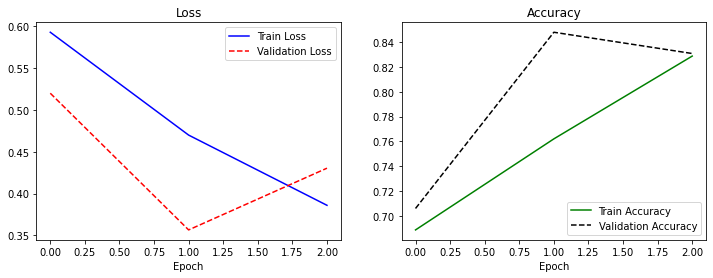

In [ ]:
keras_model_train_history = {'Train Loss': train_history.history['loss'],
                          'Validation Loss': train_history.history['val_loss'],
                          'Train Accuracy': train_history.history['acc'],
                          'Validation Accuracy': train_history.history['val_acc']}

keras_model_train_history_df = pd.DataFrame(keras_model_train_history)
keras_model_train_history_df = keras_model_train_history_df.round(4)
keras_model_train_history_df['Epoch'] = keras_model_train_history_df.reset_index().index + 1
keras_model_train_history_df = keras_model_train_history_df[['Epoch', 'Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy']]
keras_model_train_history_df.to_csv("distilbert-base-uncased_mrpc/keras_model_train_history.csv", index = False)
display(keras_model_train_history_df)
print("\n" * 4)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_history.history['loss'], 'b-', label='Train Loss')
plt.plot(train_history.history['val_loss'], 'r--', label='Validation Loss')
plt.title("Loss")
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_history.history['acc'], 'g-', label='Train Accuracy')
plt.plot(train_history.history['val_acc'], 'k--', label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.legend()

plt.show()

<br/><br/>

In [ ]:
eval_history  = model.evaluate(test_dataset_batch)

108/108 [==============================] - 7s 61ms/step - loss: 0.4029 - acc: 0.7623


<br/>

In [ ]:
output_eval_file  = 'distilbert-base-uncased_mrpc/eval_results.txt'

with open(output_eval_file, "w") as writer:
    for i, v in enumerate(list(np.round(eval_history, 4))) :
        if i == 0 :
            writer.write("Test Loss = %f\t" %(v))
        if i == 1 :
            writer.write("Test Accuracy = %f\n" %(v))

!cat distilbert-base-uncased_mrpc/eval_results.txt

Test Loss = 0.402900	Test Accuracy = 0.762300


<br/>

In [ ]:
keras_model_test_history = {'Epoch':3,
                               'Test Loss': eval_history[0],
                               'Test Accuracy': eval_history[1]}

keras_model_test_history_df = pd.DataFrame(keras_model_test_history, index=[0])
keras_model_test_history_df = keras_model_test_history_df.round(4)
keras_model_test_history_df.to_csv("distilbert-base-uncased_mrpc/keras_model_test_history.csv", index = False)
display(keras_model_test_history_df)

,Epoch,Test Loss,Test Accuracy
0,3,0.4029,0.7623


<br/>

##Huggingface Trainer

In [ ]:
#메모리를 비운다.
del model
del train_dataset_batch
del validation_dataset_batch
del test_dataset_batch

In [ ]:
pwd

'/content/drive/MyDrive/lms/huggingface_glue_task/transfomers_v4.21.1'

In [ ]:
from transformers import Trainer, TrainingArguments
output_dir = 'huggingface_trainer_mrpc'
metric_name = 'accuracy'

training_arguments = TrainingArguments(
    output_dir, # output이 저장될 경로
    evaluation_strategy="epoch", #evaluation하는 빈도
    learning_rate = 2e-5, #learning_rate
    per_device_train_batch_size = 16, # 각 device 당 batch size
    per_device_eval_batch_size = 16, # evaluation 시에 batch size
    num_train_epochs = 3, # train 시킬 총 epochs
    weight_decay = 0.01, # weight decay
    optim="adamw_torch", # defaults to 'adamw_hf'
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Trainer를 사용하기 위해서는 TrainingArguments를 통해 학습 관련 설정을 미리 지정한다.

FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version.
<br/>Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

FutureWarning을 해결하기 위해 TrainingArguments에 optim="adamw_torch"를 지정한다.

<br/>

In [ ]:
from datasets import load_metric
metric = load_metric('glue', 'mrpc')

In [ ]:
def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

Trainer의 인자로 넘겨주어야 할 것 중에 compute_metrics 메소드가 있다.
<br/>task가 classification인지 regression인지에 따라 모델의 출력 형태가 달라지므로
<br/>task별로 적합한 출력 형식을 고려해 모델의 성능을 계산하는 방법을 미리 지정한다.

In [ ]:
trainer = Trainer(
    model=huggingface_model,                           # 학습시킬 model
    args=training_arguments,                  # TrainingArguments을 통해 설정한 arguments
    train_dataset=encoded_dataset['train'],    # training dataset
    eval_dataset=encoded_dataset['validation'],       # evaluation dataset
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence2, idx, sentence1. If sentence2, idx, sentence1 are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 3668
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 690


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.547343,0.852941,0.898990
2,No log,0.646476,0.845588,0.892308
3,0.160900,0.752157,0.835784,0.887015


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence2, idx, sentence1. If sentence2, idx, sentence1 are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 408
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence2, idx, sentence1. If sentence2, idx, sentence1 are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 408
  Batch size = 16
Saving model checkpoint to huggingface_trainer_mrpc/checkpoint-500
Configuration saved in huggingface_trainer_mrpc/checkpoint-500/config.json
Model weights saved in huggingface_trainer_mrpc/checkpoint-500/pytorch_model.bin
The following

<br/><br/>

In [ ]:
def read_model_result_json(json_path):
    with open(json_path, 'r') as f:
        json_data = json.load(f)
    return json_data

,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score
0,1,0.5473,0.5473,0.8529,0.8990
1,2,0.6465,0.6465,0.8456,0.8923
2,3,0.1609,0.7522,0.8358,0.8870


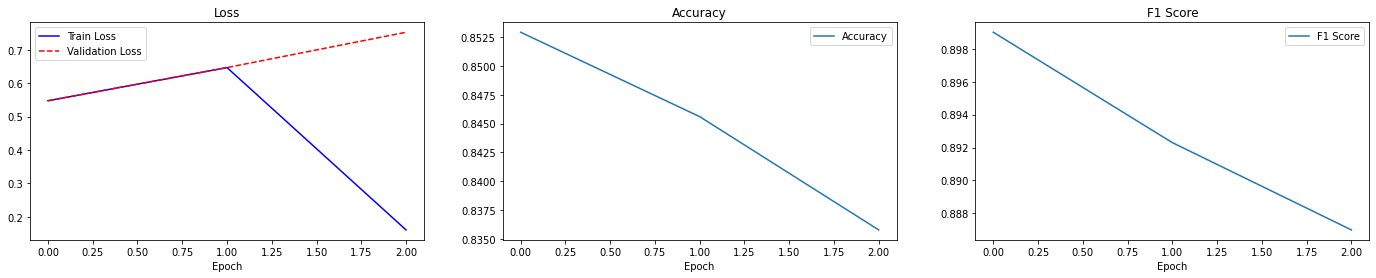

In [ ]:
json_path = 'huggingface_trainer_mrpc/checkpoint-500/trainer_state.json'

json_data = read_model_result_json(json_path)
huggingface_trainer_history_df = pd.DataFrame.from_dict(json_data['log_history'])
huggingface_trainer_history_df = huggingface_trainer_history_df[['epoch', 'eval_loss', 'eval_accuracy']]
huggingface_trainer_history_df.columns = ['Epoch', 'Train Loss', 'Accuracy']
huggingface_trainer_history_df = huggingface_trainer_history_df.dropna()
huggingface_trainer_history_df.loc[2] = [3, 0.160900, 0.835784]
huggingface_trainer_history_df.insert(2,'Validation Loss',[0.547343, 0.646476, 0.752157],True)
huggingface_trainer_history_df.insert(4,'F1 Score',[0.898990, 0.892308, 0.887015],True)
huggingface_trainer_history_df = huggingface_trainer_history_df.round(4)
huggingface_trainer_history_df = huggingface_trainer_history_df.astype({'Epoch':'int'})

huggingface_trainer_history_df.to_csv("huggingface_trainer_mrpc/huggingface_trainer_history.csv", index = False)
display(huggingface_trainer_history_df)
print("\n" * 4)

plt.figure(figsize=(24, 4))
epoch = list(huggingface_trainer_history_df['Epoch'])
train_loss = tuple(huggingface_trainer_history_df['Train Loss'])
validation_loss = tuple(huggingface_trainer_history_df['Validation Loss'])
loss = [train_loss, validation_loss]
accuracy = list(huggingface_trainer_history_df['Accuracy'])
f1_score = list(huggingface_trainer_history_df['F1 Score'])

plt.subplot(1, 3, 1)
plt.plot(train_loss, 'b-', label='Train Loss')
plt.plot(validation_loss, 'r--', label='Validation Loss')
plt.title("Loss")
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(accuracy, label='Accuracy')
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(f1_score, label='F1 Score')
plt.title("F1 Score")
plt.xlabel('Epoch')
plt.legend()

plt.show()

Trainer에 model, arguments, train_dataset, eval_dataset, compute_metrics를 넣고 train을 진행한다.

<br/><br/>

In [ ]:
eval_history = trainer.evaluate(encoded_dataset['test'])

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence2, idx, sentence1. If sentence2, idx, sentence1 are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1725
  Batch size = 16


<br/>

In [ ]:
eval_history

{'epoch': 3.0,
 'eval_accuracy': 0.823768115942029,
 'eval_f1': 0.8738589211618257,
 'eval_loss': 0.7981870174407959,
 'eval_runtime': 15.6998,
 'eval_samples_per_second': 109.874,
 'eval_steps_per_second': 6.879}

<br/>

In [ ]:
huggingface_trainer_test_history = {'Epoch': eval_history['epoch'],
                                    'Test Loss': eval_history['eval_loss'],
                                    'Test Accuracy': eval_history['eval_accuracy'],
                                    'F1 Score': eval_history['eval_f1']}

huggingface_trainer_test_history_df = pd.DataFrame(huggingface_trainer_test_history, index=[0])
huggingface_trainer_test_history_df = huggingface_trainer_test_history_df.round(4)
huggingface_trainer_test_history_df = huggingface_trainer_test_history_df.astype({'Epoch':'int'})
huggingface_trainer_test_history_df.to_csv("distilbert-base-uncased_mrpc/huggingface_trainer_test_history.csv", index = False)
display(huggingface_trainer_test_history_df)

,Epoch,Test Loss,Test Accuracy,F1 Score
0,3,0.7982,0.8238,0.8739


<br/>

##모델 평가

In [ ]:
CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))

print(colored("Keras Model Result", attrs=['bold']))
print()
display(keras_model_train_history_df)
print("\n" * 2)
display(keras_model_test_history_df)
print("\n" * 4)

print(colored("HuggingFace Trainer Result", attrs=['bold']))
print()
display(huggingface_trainer_history_df)
print("\n" * 2)
display(huggingface_trainer_test_history_df)

Keras Model Result



,Epoch,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
0,1,0.5930,0.5201,0.6886,0.7059
1,2,0.4700,0.3566,0.7620,0.8480
2,3,0.3861,0.4305,0.8288,0.8309


,Epoch,Test Loss,Test Accuracy
0,3,0.4029,0.7623







HuggingFace Trainer Result



,Epoch,Train Loss,Validation Loss,Accuracy,F1 Score
0,1,0.5473,0.5473,0.8529,0.8990
1,2,0.6465,0.6465,0.8456,0.8923
2,3,0.1609,0.7522,0.8358,0.8870


,Epoch,Test Loss,Test Accuracy,F1 Score
0,3,0.7982,0.8238,0.8739


<br/><br/>

#결론

**Virtual Environment VS Github Contributor**

HuggingFace에 등록된 MRPC 모델의 CLI 코드를 실행했다.
<br/>bert-base-cased MRPC Finetune
<br/>bert-base-uncased MRPC Finetune
<br/>bert_uncased_L-12_H-768_A-12 MRPC Finetune

Tensorflow 버전 차이 때문에 AttributeError, TyperError가 발생한다.
<br/>py 파일을 여러 번 수정해도 또 다른 에러가 떠서 아예 코드 전체를 바꿔야 하는 디버깅 작업이 요구된다.


이러한 상황에서 그 작동 코드의 옛날 버전에 맞는 가상환경을 구축하거나
<br/>코드 전체를 바꿔서 원작자에게 연락하여 Github Contributor가 되는 문제 해결 방법이 있는 것인가?
<br/>개발자는 모델 개발과 배포 프로세스에서 발생한 이슈에 어떻게 대처하는가?

**HuggingFrace MNLI Custom Project 코드 변경 예정**

[Disaster Tweets : multiple vectorizers and models](https://www.kaggle.com/code/zinebkhanjari/disaster-tweets-multiple-vectorizers-and-models/notebook?scriptVersionId=52721572)

ElectraTokenizerFast.from_pretrained와 lectraForSequenceClassification.from_pretrained에서
<br/>모델 [google/electra-base-discriminator](https://huggingface.co/google/electra-base-discriminator)를 작동시키기 위해서는 모델 구성, 학습, 평가 코드를 수정한다.
<br/><br/>모델 구성
* Tokenizer & Model
* Huggingface Auto Classes
* Tokenizing

Keras Moodel
<br/>Huggingface Trainer
<br/><br/>ElectraForSequenceClassification.from_pretrained has no attruibute 'model.compile' 에러가 떠서 코드가 실행되지 않는다.
<br/>따라서 위의 Kaggle 사이트에 따라 코드를 수정하여 HuggingFrace MNLI Custom Project를 수행할 예정이다. 


<br/>

#참고문헌

**LMS**
<br/>[mjmingd](https://github.com/mjmingd)

<br/>**공식 사이트**
<br/>DACON
<br/>[뉴스 토픽 분류 AI 경진대회 private 27위 TwoKimBrothers팀 코드공유](https://dacon.io/competitions/official/235747/codeshare/3050)

<br/>**Github**
<br/>HuggingFace
<br/>[Transformers Release](https://github.com/huggingface/transformers/releases)
<br/><br/>sgugger
<br/>[# v4.21.1: Patch release](https://github.com/huggingface/transformers/releases/tag/v4.21.1)
<br/><br/>Beomi
<br/>[2021-03-15-kcbert-mlm-finetune-with-petition-dataset.ipynb](https://gist.github.com/Beomi/972c6442a9c15a22dfd1903d0bb0f577)
<br/>[KcBERT MLM Finetune으로 Domain adaptation하기](https://beomi.github.io/2021/03/15/KcBERT-MLM-Finetune/)
<br/><br/>jacobdevlin-google
<br/>[google-research/bert/Sentence (and sentence-pair) classification tasks](https://github.com/google-research/bert)
<br/><br/>W4ngatan
<br/>[download_glue_data.py](https://gist.github.com/W4ngatang/60c2bdb54d156a41194446737ce03e2e)
<br/><br/>vlasenkoalexe
<br/>[download_glue_data.py (fixed script)](https://gist.github.com/vlasenkoalexey/fef1601580f269eca73bf26a198595f3)
<br/><br/>birdmw
<br/>[AttributeError: module 'tensorflow' has no attribute 'flags' #1754](https://github.com/tensorflow/tensor2tensor/issues/1754)
<br/><br/>Gabriel-Molinas
<br/>[AttributeError: module 'tensorflow' has no attribute 'app' #34431](https://github.com/tensorflow/tensorflow/issues/34431)
<br/><br/>Zhen-Dong
<br/>[QBERT/NLP-quantization/Fine-tuning with BERT: examples](https://githubmemory.com/index.php/repo/Zhen-Dong/QBERT)

<br/>**Hugging Face**
<br/>[Installation](https://huggingface.co/docs/transformers/installation#installing-from-source%60)
<br/>[Transformers Examples](https://huggingface.co/transformers/v2.9.1/examples.html)
<br/>[beomi/kcbert-base](https://huggingface.co/beomi/kcbert-base)
<br/>[bert-base-cased](https://huggingface.co/bert-base-cased)
<br/>[bert-base-uncased](https://huggingface.co/bert-base-uncased)
<br/>[google/bert_uncased_L-12_H-768_A-12](https://huggingface.co/google/bert_uncased_L-12_H-768_A-12/tree/main)
<br/>[google/electra-base-discriminator](https://huggingface.co/google/electra-base-discriminator)
<br/>[distilbert-base-uncased](https://huggingface.co/distilbert-base-uncased)
<br/>[Huggingface transformers longformer optimizer warning AdamW](https://discuss.huggingface.co/t/huggingface-transformers-longformer-optimizer-warning-adamw/14711/3)
<br/>[run_glue.py with my own dataset of one-sentence input](https://discuss.huggingface.co/t/run-glue-py-with-my-own-dataset-of-one-sentence-input/3098/6)

<br/>**Kaggle**
<br/>[huggingface transformer basic usage](https://www.kaggle.com/code/nageshsingh/huggingface-transformer-basic-usage)
<br/>[Trainer](https://huggingface.co/docs/transformers/main_classes/trainer)
<br/>[Disaster Tweets : multiple vectorizers and models](https://www.kaggle.com/code/zinebkhanjari/disaster-tweets-multiple-vectorizers-and-models/notebook?scriptVersionId=52721572)

<br/>**웹사이트**
<br/>[PYTORCH / HUGGINGFACE CUSTOM DATASET으로 BERT 학습하기 – GPU](https://cryptosalamander.tistory.com/141)
<br/>[git 특정 tag clone 하기. git clone -b tag repositor y](https://junho85.pe.kr/433)
<br/>[Error in google colab(python) while transliterating data into Indian language](https://stackoverflow.com/questions/73024976/error-in-google-colabpython-while-transliterating-data-into-indian-language)
<br/>[Pretty printing newlines inside a string in a Pandas DataFrame](https://stackoverflow.com/questions/34322448/pretty-printing-newlines-inside-a-string-in-a-pandas-dataframe)
<br/>[Python: how to slice a dictionary based on the values of its keys?](https://stackoverflow.com/questions/40440373/python-how-to-slice-a-dictionary-based-on-the-values-of-its-keys)
<br/>[Error importing BERT: module 'tensorflow._api.v2.train' has no attribute 'Optimizer'](https://stackoverflow.com/questions/61250311/error-importing-bert-module-tensorflow-api-v2-train-has-no-attribute-optimi)
<br/>[AttributeError: module 'tensorflow' has no attribute 'logging'](https://systemout.tistory.com/8)
<br/>[Wikipedia Apollo program](https://en.wikipedia.org/wiki/Apollo_program)
<br/>[How to reorder indexed rows based on a list in Pandas data frame](https://www.google.com/search?q=info.splits&oq=info.splits&aqs=chrome..69i57.395j0j9&sourceid=chrome&ie=UTF-8)
<br/>[Print the structure of large nested dictionaries in a compact way without printing all elements](https://stackoverflow.com/questions/39334638/print-the-structure-of-large-nested-dictionaries-in-a-compact-way-without-printi)
<br/>[Python Pandas: Convert nested dictionary to dataframe](https://stackoverflow.com/questions/31460234/python-pandas-convert-nested-dictionary-to-datafram)
<br/>[TPU를 이용한 BERT GLUE task Train, Evaluation 해보기](https://choice-life.tistory.com/77)
<br/>[How to reorder a python ordered dict based on array?](https://stackoverflow.com/questions/18405537/how-to-reorder-a-python-ordered-dict-based-on-array)
<br/>[Convert Ordereddict into dataframe in python](https://stackoverflow.com/questions/68797498/convert-ordereddict-into-dataframe-in-python)
<br/>[Constructing pandas DataFrame from values in variables gives "ValueError: If using all scalar values, you must pass an index"](https://stackoverflow.com/questions/17839973/constructing-pandas-dataframe-from-values-in-variables-gives-valueerror-if-usi)
<br/>[matplotlib label doesn't work](https://stackoverflow.com/questions/14657169/matplotlib-label-doesnt-work)